# importing modules and data_wrangling notebooks

In [1]:
#used to stop program under certain conditions
from sys import exit

#dataframes and numerical processes
import pandas as pd
import numpy as np

#importing database from file or online
import csv
from urllib import request
from sodapy import Socrata

#for linear fitting
from sklearn import linear_model
from scipy import stats

#Do not display warnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

#import population and opioid data from Data_wrangling notebook
from ipynb.fs.defs.data_wrangling import create_pop_dataframe,add_temperature_to_dataframe,create_opioid_dataframe
population_df,location_pop=create_pop_dataframe()
population_df,temperature_df= add_temperature_to_dataframe(population_df) 
opioid_df,opioid_reduced = create_opioid_dataframe(population_df)

# health providers: 1049326
# health providers who prescribe opioid: 496744
% health providers that prescribe opioids: 47.34%
# specialities: 246
# specialities that prescribe opioid: 169
Max % prescriptions that are opioids: 100.00%
Min % prescriptions that are opioids(other than zero): 0.03%
Missing population for 1820 (0.17%) entries


# Opioid prescribed of a city population
As we can see below, the number of opioid claims increases with city population(r=0.86). This is what is expected; as the size of the population increases, the number of people who would be prescribed opioids also increases. But when we switch from total opioid claims to percentage of claims that are for opioids, the trends change. For smaller cities with lower population ranges, there is a huge range of percentage opioid claims, with values reaching as high as 100%. On closer inspection (see the scatterplot of populations <80,000) it is clear that an inverse relation between population size and percentage opioid claims exists. The maximum opioid prescribed percentages settles in the range 5-10%. As the number of claims increase with population, any health care provider who prescribed high levels of opioids is unlikely to have a large influence on the overall percentages; this most likely the reason why this inverse relation between population and upper levels opioid claims percentages. 
Opoid claims percentages of weakly inversely correlated with population(r=0.021) but this correlation is statitically significant (p<0.05). 

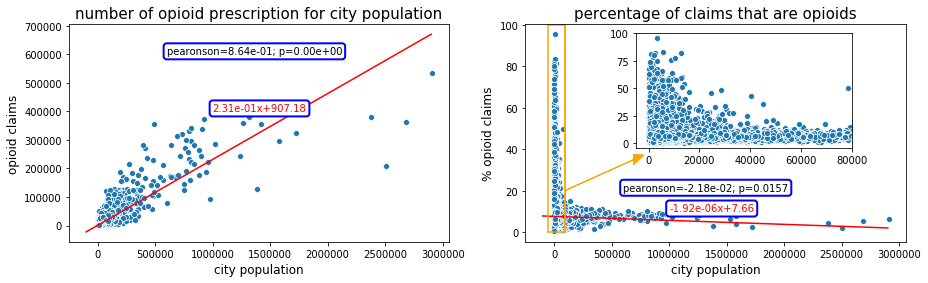

In [2]:
sum_claims = opioid_reduced.groupby(['state_id','city'])['city','state_id','opioid claims','total claims'].sum().reset_index()
sum_claims = sum_claims.merge(location_pop,on=['state_id','city'])
sum_claims=sum_claims[sum_claims['population']!= 0]
sum_claims['percent opioid claims'] = sum_claims[['opioid claims','total claims']].apply(lambda x: x[0]/x[1]*100,axis=1)

#figures for opioid perscribed vs population analysis  
fig = plt.figure(figsize=(15,4))
#Number of prescrition
ax1 = fig.add_subplot(1,2,1)
sns.scatterplot(x=sum_claims['population'],y=sum_claims['opioid claims'],ax=ax1)
ax1.set_title('number of opioid prescription for city population',fontsize=15)
ax1.set_ylabel('opioid claims',fontsize=12)
ax1.set_xlabel('city population',fontsize=12)

#linear regression
lm = linear_model.LinearRegression()
x = sum_claims[['population']]
y = sum_claims['opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-1E5,3E6,1E5)
y_fit = slope*x_fit+intercept
ax1.plot(x_fit,y_fit,color='red')
text=format(slope,'.2e') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax1.text(s=text,x=1E6,y=4E5,color='red',bbox=bbox_props)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(sum_claims['population'],sum_claims['opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax1.text(s=text,x=6E5,y=6E5,bbox=bbox_props)



#Fraction of prescrition
ax2 = fig.add_subplot(1,2,2)
sns.scatterplot(x=sum_claims['population'],y=sum_claims['percent opioid claims'],ax=ax2)
ax2.set_title('percentage of claims that are opioids',fontsize=15)
ax2.set_xlabel('city population',fontsize=12)
ax2.set_ylabel('% opioid claims',fontsize=12)

#linear regression
lm = linear_model.LinearRegression()
x = sum_claims[['population']]
y = sum_claims['percent opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-1E5,3E6,1E5)
y_fit = slope*x_fit+intercept
ax2.plot(x_fit,y_fit,color='red')
text=format(slope,'.2e') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(s=text,x=1E6,y=10,color='red',bbox=bbox_props)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(sum_claims['population'],sum_claims['percent opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.4f')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax2.text(s=text,x=6E5,y=20,bbox=bbox_props)





#plot inside plot
x_state = 0.65 # x origin of the inside plot
y_state = 0.45 # y origin of the inside plot
x_size = 0.2 # x size of inside plot
y_size = 0.4 # y size of inside plot
inside = fig.add_axes([x_state, y_state, x_size, y_size])
sns.scatterplot(x=sum_claims['population'],y=sum_claims['percent opioid claims'],ax=inside)
inside.set_xlabel('')
inside.set_ylabel('')
inside.set_xlim((-5000,80000))


#add annotation to draw attention to outlier region
l = mlines.Line2D([-50000,90000], [0,0],color='orange')
ax2.add_line(l)
l = mlines.Line2D([-50000,-50000], [0,100],color='orange')
ax2.add_line(l)
l = mlines.Line2D([-50000,90000], [100,100],color='orange')
ax2.add_line(l)
l = mlines.Line2D([90000,90000], [0,100],color='orange')
ax2.add_line(l)
ax2.arrow(90000,20,600000,15,color='orange',head_width=5, head_length=90000)
ax2.add_line(l)

fig.savefig('population_analysis.jpg',bbox_inches='tight')
plt.show()

###### Creating population bins to examine the maximum values

In [3]:
sum_claims['population bin'] =sum_claims['population']//10000*10000
sum_claims.groupby('population bin').max()[['opioid claims','total claims','percent opioid claims']]

,opioid claims,total claims,percent opioid claims
population bin,,,
0.0,22682,297857,95.454545
10000.0,51088,504818,81.602003
20000.0,35877,473491,48.181818
30000.0,49790,611306,33.766234
40000.0,59911,740515,43.203883
50000.0,71288,838496,18.623712
60000.0,76413,818566,17.631814
70000.0,122766,1450710,49.797563
80000.0,94877,1093661,14.400676


# Opioids subscribed by  healthcare providers

As shown in the two histograms below, the left presents the number of opioid claims by prescribed by healthcare providers and the right presents percentage of drug claims that are opioids prescribed by healthcare providers. As shown, the majority of healthcare providers each provided <25 opioid prescriptions for their patients in 2013; which consisted of about 0%-15% of drug claims. 

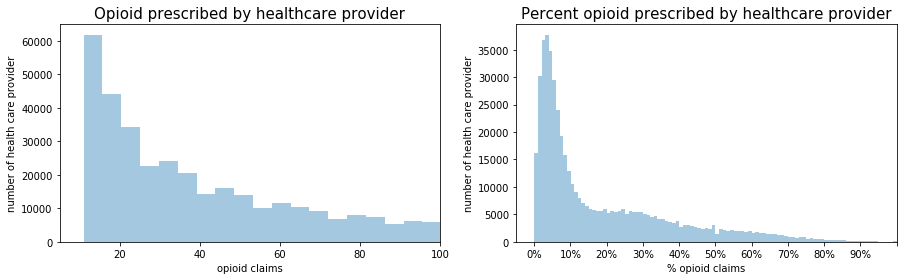

,percent opioid claims
percent opioid bin,
0,15404
1,29955
2,36648
3,37702
4,34879
5,29697
6,24133
7,19418
8,15948


In [4]:
fig = plt.figure(figsize=(15,4)) 

# histagram of sopioid
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Opioid prescribed by healthcare provider',fontsize=15)
sns.distplot(opioid_reduced[opioid_reduced['opioid claims'] < 200]['opioid claims'],bins=40,ax=ax1,kde=False,hist=True)
ax1.set_ylabel('number of health care provider')
ax1.set_xlim(5,100)

ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Percent opioid prescribed by healthcare provider',fontsize=15)
sns.distplot(opioid_reduced['percent opioid claims'],bins=100,ax=ax2,kde=False,hist=True)
ax2.set_ylabel('number of health care provider')
ax2.set_xlabel('% opioid claims')
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%'))
ax2.set_xlim(-5,100)


fig.savefig('provider_analysis.jpg',bbox_inches='tight')
plt.show()

bin_percent = opioid_reduced.copy()

bin_percent['percent opioid bin'] =bin_percent['percent opioid claims']//1
bin_percent['percent opioid bin'] = bin_percent['percent opioid bin'].astype(int)
bin_percent.groupby('percent opioid bin').count()[['percent opioid claims']].head(20)

# Opioid prescribed by clinicians

Below we examine the amount of opioid prescriptions of the ten top prescribers by speciality. Medicare Part D patients are prescribed opioids more frequently by family practice and internal medicine physicians than any specialist, 21.6 million and 18.9 million in total, respectively. The third most frequent prescribers of opioids, nurse practitioners, are responsible for far fewer opioid claims, 6.4 million. Interesting, only about 5.5% and 4.6% of the total number of prescriptions by family practice  and internal medicine physicians respectively were opioids. Family practice and internal medicine physicians treat a broad range of illnesses and disorders and are generally the first clinicians that patients consult for any complaint. This can explain why these two groups are responsible for far more opioid claims but opioids only include a small portion of their prescriptions. Orthopedic surgery, physical medicine and rehabilitation, anesthesiology, and interventional pain management are the most frequent prescribers of opioids; with more than 40% of their prescriptions falling into that category. This would be expected because two treat patients in or recovering from pain (physical medicine and rehabilitation and interventional pain management) and two perform surgeries (orthopedic surgery and anesthesiology) for which opioids are commonly given for post-operative pain.

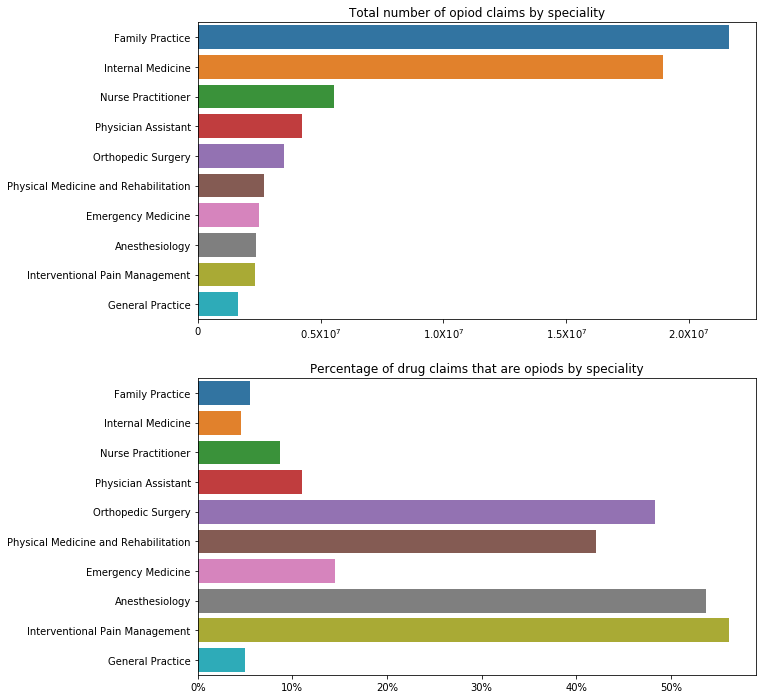

In [5]:
specialty_sum=opioid_reduced.groupby('specialty description').sum()[['opioid claims','total claims']].sort_values(by='opioid claims',ascending=False)
specialty_sum['percent opioid claims'] = specialty_sum['opioid claims']/specialty_sum['total claims']*100
specialty_top = specialty_sum.head(10)
specialty_list=specialty_top.index.tolist()

fig = plt.figure(figsize=(10,12))


ax1 = fig.add_subplot(2,1,1)
plt.xticks((0,0.5E7,1E7,1.5E7,2E7),('0','0.5X$10^7$','1.0X$10^7$','1.5X$10^7$','2.0X$10^7$'))
sns.barplot(y=specialty_top.index,x=specialty_top['opioid claims'],order=specialty_list,ax=ax1)
ax1.set_title('Total number of opiod claims by speciality')
ax1.set_ylabel('')
ax1.set_xlabel('')



ax2 = fig.add_subplot(2,1,2)
sns.barplot(y=specialty_top.index,x=specialty_top['percent opioid claims'],order=specialty_list,ax=ax2)
ax2.set_title('Percentage of drug claims that are opiods by speciality')
plt.xticks((0,10,20,30,40,50),('0%','10%','20%','30%','40%','50%'))
ax2.set_ylabel('')
ax2.set_xlabel('')

fig.savefig('speciality_analysis.jpg',bbox_inches='tight')
plt.show()

# Range of opioid prescription by clinicians

Below, we examine the range of percentages of opioid prescribed by the specialists from the previous bar charts. While family practice, internal medicine, and general practice physicians have narrow spreads of their percentages (the whiskers in their boxes range from 0% to 14%), they have outliers that reach 100%. However, their outliers are only about 6% of the total number of healthcare providers in those categories. Healthcare providers are considered outliers of their specialty if their percentage of their opioid claims are outside the first and third quartile by 1.5 the interquartile ranges (difference of the first to third quartile). Physical medicine and rehabilitation’s boxplot has a whiskers span of 0% to 100% while orthopedic surgery, physician assistant, and anesthesiology’s whiskers span most of this range. All of the top ten prescribers of opioids, as outliers or in the normal range of the plot, span 0 to 100%. Despite the wide range of values, only general practice had more than 10% of healthcare providers as outliers, at 11%. Nurse practitioner were slightly below at 9%. While it makes sense that specialties that deal with pain relief or surgery would have a wide range, that family practice and internal medicine healthcare providers have a significant number of outliers suggests that they are too lenient with opioid prescriptions 


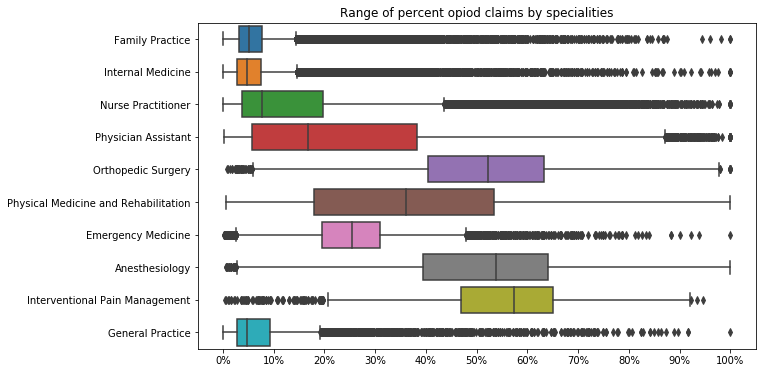

,median,1Q,3Q,top whisk,bottom whisk,# outliers,# providers,% outliers
specialty description,,,,,,,,
Family Practice,5.09,3.28,7.72,14.37,0.00,5267,84070,6.27
Internal Medicine,4.74,2.85,7.55,14.60,0.00,4826,82311,5.86
Nurse Practitioner,7.68,3.77,19.72,43.66,0.00,3883,43495,8.93
Physician Assistant,16.83,5.67,38.24,87.10,0.00,204,40308,0.51
Orthopedic Surgery,52.26,40.35,63.35,97.86,5.85,52,19969,0.26
Physical Medicine and Rehabilitation,36.09,17.87,53.45,100.00,0.00,0,6164,0.00
Emergency Medicine,25.55,19.62,30.97,47.99,2.60,642,36000,1.78
Anesthesiology,53.77,39.48,64.06,100.00,2.61,24,3562,0.67
Interventional Pain Management,57.42,46.90,65.00,92.15,19.75,93,1865,4.99


In [6]:
opioid_top = opioid_reduced[opioid_reduced['specialty description'].apply(lambda x:
                                                             True if x in specialty_list else False)]


fig = plt.figure(figsize=(10,6))
sns.boxplot(y='specialty description',x='percent opioid claims',data=opioid_top,order=specialty_list)
plt.xticks((0,10,20,30,40,50,60,70,80,90,100),('0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'))
plt.title('Range of percent opiod claims by specialities')
plt.ylabel('')
plt.xlabel('')
fig.savefig('speciality_range.jpg',bbox_inches='tight')
plt.show()


opioid_top_des = opioid_top.groupby('specialty description').median()[['percent opioid claims']]
opioid_top_des.rename(columns={'percent opioid claims':'median'},inplace=True)
opioid_top_des = opioid_top_des.reindex(specialty_list)


opioid_top_des['1Q'] = opioid_top.groupby('specialty description').quantile(.25)['percent opioid claims']
opioid_top_des['3Q'] = opioid_top.groupby('specialty description').quantile(.75)['percent opioid claims']
opioid_top_des['top whisk'] = opioid_top_des[['1Q','3Q']].apply(lambda x:
                                                                        x[1] + 1.5*(x[1]- x[0])
                                                                        if x[1] + 1.5*(x[1]- x[0]) < 100
                                                                        else 100,axis=1)
opioid_top_des['bottom whisk'] = opioid_top_des[['1Q','3Q']].apply(lambda x:
                                                                            x[0] - 1.5*(x[1]- x[0]) 
                                                                            if x[0] - 1.5*(x[1]- x[0])  > 0
                                                                            else 0,axis=1)


#Count outliers
outliers =  pd.DataFrame()
alllist = pd.DataFrame()
for specialty in specialty_list:
    min = opioid_top_des['bottom whisk'][specialty]
    max = opioid_top_des['top whisk'][specialty]
    df =opioid_reduced[(opioid_reduced['specialty description']== specialty)
                   & ((opioid_reduced['percent opioid claims'] > max)
                      | (opioid_reduced['percent opioid claims'] < min))]
    outliers= pd.concat([outliers,df])
    
#opioid_top_des['mean'] = outliers.groupby('specialty description').mean()['percent opioid claims']
#opioid_top_des['std dev'] = outliers.groupby('specialty description').std()['percent opioid claims']

opioid_top_des['# outliers'] = outliers.groupby('specialty description').count()['percent opioid claims']
opioid_top_des.fillna(0, inplace=True)
opioid_top_des['# outliers'] = opioid_top_des['# outliers'].astype(int)
opioid_top_des['# providers'] = opioid_reduced.groupby('specialty description').count()['percent opioid claims'].astype(int)
opioid_top_des['% outliers'] = opioid_top_des['# outliers']/opioid_top_des['# providers']*100
#print database
opioid_top_des.round(2)


# Correlation between City Population and Opioid Prescription
Besides speciality, there is a question on what other factors contribute to the amount of opioid prescription. Including more important factors in a machine learning algorithm may increase the predictable capability of the model. While it has been established city's population is correlated to its total opioid claims and weakly (but statistically significantly) to opioid claims percentages, the same cannot be said to the opioid claims of an individual healthcare provider.  Below the correlation with number of opioid claims and percent opioid claims of a healthcare provider to city population was examined. Both were weakly correlated with population and statistically significant (p < 0.05) with total opioid claims surprisingly negatively correlated. Because the correlation is weak, the ability of population to detect outlier opioid claims is suspect. 

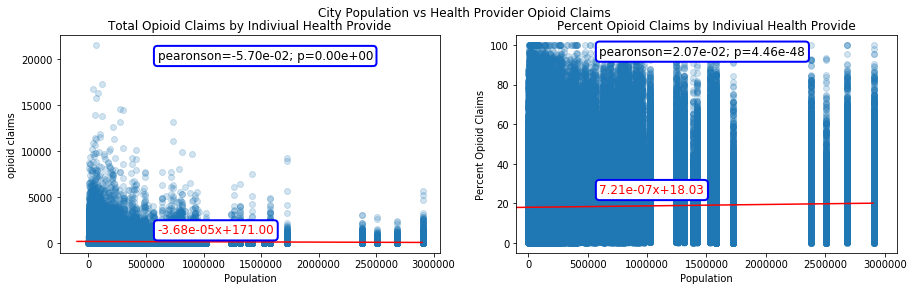

In [25]:
fig = plt.figure(figsize=(15,4))

plt.suptitle('City Population vs Health Provider Opioid Claims')

#population vs opioid claims by indiviual health provide
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Total Opioid Claims by Indiviual Health Provide')
ax1.set_ylabel('opioid claims')
ax1.set_xlabel('Population')

#scatter plot
ax1.scatter(x=opioid_reduced['population'],y=opioid_reduced['opioid claims'],alpha=0.2)

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['population']]
y = opioid_reduced['opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-1E5,3E6,1E5)
y_fit = slope*x_fit+intercept
ax1.plot(x_fit,y_fit,color='red')
text=format(slope,'.2e') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax1.text(s=text,x=6.0E5,y=1000,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['population'],opioid_reduced['opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax1.text(s=text,x=6.0E5,y=2E4,bbox=bbox_props,fontsize=textsize)



#population vs percentage opioid claims by indiviual health provide

#Scatter plot 
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Percent Opioid Claims by Indiviual Health Provide')
ax2.set_ylabel('Percent Opioid Claims')
ax2.set_xlabel('Population')
ax2.set_xlim(-1E5,3.1E6)

#scatter plot
ax2.scatter(x=opioid_reduced['population'],y=opioid_reduced['percent opioid claims'],alpha=0.2)

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['population']]
y = opioid_reduced['percent opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-1E6,3E6,1E5)
y_fit = slope*x_fit+intercept
ax2.plot(x_fit,y_fit,color='red')
text=format(slope,'.2e') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(s=text,x=6.0E5,y=25,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['population'],opioid_reduced['percent opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax2.text(s=text,x=6.0E5,y=95,bbox=bbox_props,fontsize=textsize)

fig.savefig('population_stat.jpg',bbox_inches='tight')

plt.show()


# Correlation between City Temperature and Opioid Prescription
Below, the correlation between the mean, lowest, and highest city temperature of 2013 with the total and percentage opioid claim of the healthcare provider is examined. Because number temperatures may make the symptoms opioids treat worst, it is plausible that temperature may be a useful attribute in outlier detection. All three attributed (mean, lowest, and highest city temperature) were weakly negative correlated with both percentage opioid claims of a healthcare provider and positively correlated with total opioid claims. The correlation was statistically significant (p < 0.05) but because it is weak, the predictability of temperature in detecting opioid claim outliers is suspect. The correlations of number of opioid claims and percent of opioid claims handled different cells.

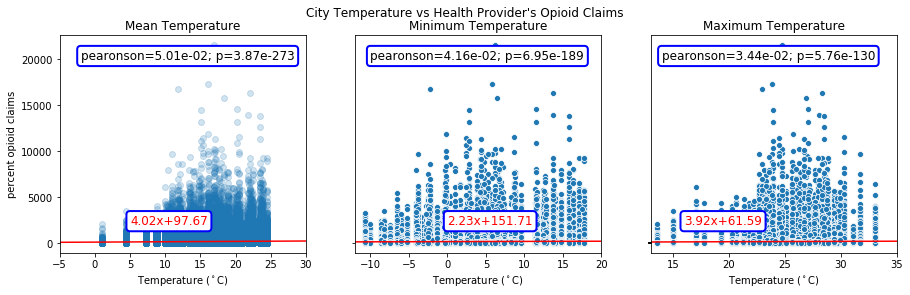

In [9]:
#City temperature vs total opioid claims
fig = plt.figure(figsize=(15,4))

plt.suptitle('City Temperature vs Health Provider\'s Opioid Claims')
textsize=12

#Mean temperature
ax1 = fig.add_subplot(1,3,1)
plt.xlim(-5,30)
ax1.set_ylabel('percent opioid claims')
ax1.set_xlabel('Temperature ($^\circ$C)')
ax1.set_title('Mean Temperature')

#scatter plot
ax1.scatter(x=opioid_reduced['Mean Temp'],y=opioid_reduced['opioid claims'],alpha=0.2)

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Mean Temp']]
y = opioid_reduced['opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-10,50,1)
y_fit = slope*x_fit+intercept
ax1.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax1.text(s=text,x=5,y=2000,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Mean Temp'],opioid_reduced['opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax1.text(s=text,x=-2,y=20000,bbox=bbox_props,fontsize=textsize)


#minimum temperature
ax2 = fig.add_subplot(1,3,2)
plt.xlim(-12,20)
sns.scatterplot(x=opioid_reduced['Min Temp'],y=opioid_reduced['opioid claims'],ax=ax2)
ax2.set_xlabel('Temperature ($^\circ$C)')
ax2.set_ylabel('')
ax2.set_title('Minimum Temperature')
plt.yticks([0],[''])

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Min Temp']]
y = opioid_reduced['opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-12,22,1)
y_fit = slope*x_fit+intercept
ax2.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(s=text,x=0,y=2000,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Min Temp'],opioid_reduced['opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax2.text(s=text,x=-10,y=20000,bbox=bbox_props,fontsize=textsize)

#maximum temperature
ax3 = fig.add_subplot(1,3,3)
plt.xlim(13,35)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],['','','','','','','','','','',''])

#scatter plot
sns.scatterplot(x=opioid_reduced['Max Temp'],y=opioid_reduced['opioid claims'],ax=ax3)

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Max Temp']]
y = opioid_reduced['opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(13,40,1)
y_fit = slope*x_fit+intercept
ax3.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax3.text(s=text,x=16,y=2000,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Max Temp'],opioid_reduced['opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax3.text(s=text,x=14,y=20000,bbox=bbox_props,fontsize=textsize)

ax3.set_xlabel('Temperature ($^\circ$C)')
ax3.set_ylabel('')
ax3.set_title('Maximum Temperature')

plt.show()

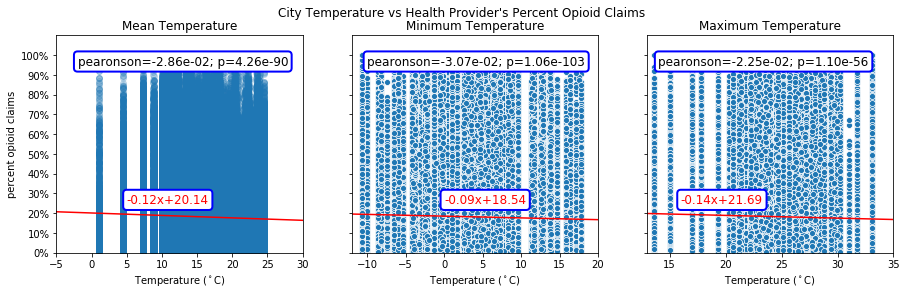

In [25]:
#City temperature vs percent opioid claims
fig = plt.figure(figsize=(15,4))

plt.suptitle('City Temperature vs Health Provider\'s Percent Opioid Claims')
textsize=12

#Mean temperature
ax1 = fig.add_subplot(1,3,1)
plt.xlim(-5,30)
plt.ylim(0,110)
ax1.set_ylabel('percent opioid claims')
ax1.set_xlabel('Temperature ($^\circ$C)')
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
ax1.set_title('Mean Temperature')

#scatter plot
ax1.scatter(x=opioid_reduced['Mean Temp'],y=opioid_reduced['percent opioid claims'],alpha=0.2)

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Mean Temp']]
y = opioid_reduced['percent opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-10,50,1)
y_fit = slope*x_fit+intercept
ax1.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax1.text(s=text,x=5,y=25,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Mean Temp'],opioid_reduced['percent opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax1.text(s=text,x=-2,y=95,bbox=bbox_props,fontsize=textsize)


#Minimum temperature
ax2 = fig.add_subplot(1,3,2)
plt.xlim(-12,20)
plt.ylim(0,110)
sns.scatterplot(x=opioid_reduced['Min Temp'],y=opioid_reduced['percent opioid claims'],ax=ax2)
ax2.set_xlabel('Temperature ($^\circ$C)')
ax2.set_ylabel('')
ax2.set_title('Minimum Temperature')
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],['','','','','','','','','','',''])

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Min Temp']]
y = opioid_reduced['percent opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-12,22,1)
y_fit = slope*x_fit+intercept
ax2.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(s=text,x=0,y=25,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Min Temp'],opioid_reduced['percent opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax2.text(s=text,x=-10,y=95,bbox=bbox_props,fontsize=textsize)


#maximum temperature
ax3 = fig.add_subplot(1,3,3)
plt.xlim(13,35)
plt.ylim(0,110)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],['','','','','','','','','','',''])


#scatter plot
sns.scatterplot(x=opioid_reduced['Max Temp'],y=opioid_reduced['percent opioid claims'],ax=ax3)

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Max Temp']]
y = opioid_reduced['percent opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(13,40,1)
y_fit = slope*x_fit+intercept
ax3.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax3.text(s=text,x=16,y=25,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Max Temp'],opioid_reduced['percent opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax3.text(s=text,x=14,y=95,bbox=bbox_props,fontsize=textsize)

ax3.set_title('Maximum Temperature')
ax3.set_ylabel('')
ax3.set_xlabel('Temperature ($^\circ$C)')

plt.show()

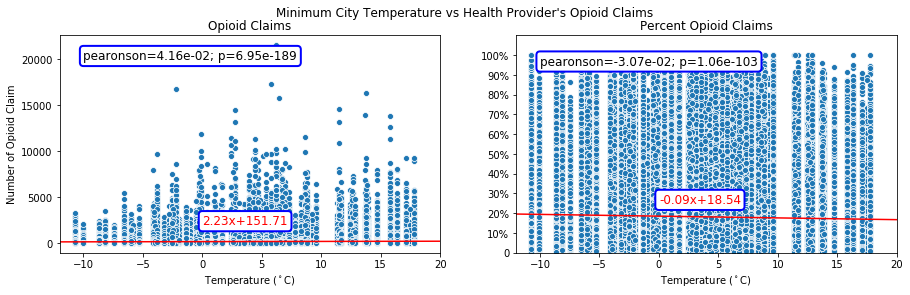

In [26]:
fig = plt.figure(figsize=(15,4))

plt.suptitle('Minimum City Temperature vs Health Provider\'s Opioid Claims')
textsize=12

#number of opioid claims 
ax2 = fig.add_subplot(1,2,1)
plt.xlim(-12,20)
sns.scatterplot(x=opioid_reduced['Min Temp'],y=opioid_reduced['opioid claims'],ax=ax2)
ax2.set_xlabel('Temperature ($^\circ$C)')
ax2.set_ylabel('Number of Opioid Claim')
ax2.set_title('Opioid Claims')

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Min Temp']]
y = opioid_reduced['opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-12,22,1)
y_fit = slope*x_fit+intercept
ax2.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(s=text,x=0,y=2000,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Min Temp'],opioid_reduced['opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax2.text(s=text,x=-10,y=20000,bbox=bbox_props,fontsize=textsize)




#Minimum temperature
ax2 = fig.add_subplot(1,2,2)
plt.xlim(-12,20)
plt.ylim(0,110)
sns.scatterplot(x=opioid_reduced['Min Temp'],y=opioid_reduced['percent opioid claims'],ax=ax2)
ax2.set_xlabel('Temperature ($^\circ$C)')
ax2.set_ylabel('')
ax2.set_title('Percent Opioid Claims')
plt.yticks([0,10,20,30,40,50,60,70,80,90,100],['0','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])

#linear regression
lm = linear_model.LinearRegression()
x = opioid_reduced[['Min Temp']]
y = opioid_reduced['percent opioid claims']
lm.fit(x,y)
intercept = float(lm.intercept_)
slope = float(lm.coef_)
x_fit = np.arange(-12,22,1)
y_fit = slope*x_fit+intercept
ax2.plot(x_fit,y_fit,color='red')
text=format(slope,'.2f') + 'x+'+ format(intercept,'.2f') 
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="b", lw=2)
ax2.text(s=text,x=0,y=25,color='red',bbox=bbox_props,fontsize=textsize)

#show Pearson Correlation and p value
pearson,pvalue=stats.pearsonr(opioid_reduced['Min Temp'],opioid_reduced['percent opioid claims'])
text = 'pearonson=' + format(pearson,'.2e') + '; p=' + format(pvalue,'.2e')
bbox_props = dict(boxstyle="round",pad=0.3, fc="white", ec="b", lw=2)
ax2.text(s=text,x=-10,y=95,bbox=bbox_props,fontsize=textsize)

fig.savefig('temperature_stat.jpg',bbox_inches='tight')

plt.show()